## Kütüphaneler

In [11]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from tensorflow.keras.models import load_model
from sklearn.preprocessing import MinMaxScaler
import yfinance as yf

# Ayarlanabilir Parametreler

In [12]:
ticker_symbol = '^N225'  # Hedef Borsa
start_date = '2010-01-01'
end_date = '2024-12-20' 
n_days = 5  # Tahmin edeceği gün sayısı
last_n_days = 10  # Ek analizler için son kaç gün dikkate alınacak

# Veri Çekme ve Model Yükleme

Eğittiğimiz modeli uygulamamıza dahil etme işlemi

In [13]:
ticker = yf.Ticker(ticker_symbol)
borsa_adi = ticker.info['shortName']
print(f"Borsanın Orijinal Adı: {borsa_adi}")

current_directory = os.getcwd()
model_path = os.path.join(current_directory, ticker_symbol + ".h5")
print(model_path)
model = load_model(model_path)
#print("Model başarıyla yüklendi.")

Borsanın Orijinal Adı: Nikkei 225
c:\Users\Alperen\Desktop\Ver 0.6\Ver 0.2\^N225.h5


# Veriyi İndirme ve Ölçeklendirme
Belirlediğimiz hisse senedinin geçmişteki fiyat verilerini alıp, kapanış fiyatlarını normalize etme işlemi

In [14]:
data = yf.download(ticker_symbol, start=start_date, end=end_date)
close_prices = data['Close'].values.reshape(-1, 1)  # Son kapanış fiyatları
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(close_prices)

[*********************100%***********************]  1 of 1 completed


# Tahmin İşlemleri

In [15]:

last_60_days = scaled_data[-60:]  # Modelin kullanacağı son 60 gün
temp_input = list(last_60_days.flatten())
predictions = []

future_dates = [data.index[-1] + timedelta(days=i + 1) for i in range(n_days)]

for i in range(n_days):
    X_test = np.array(temp_input[-60:]).reshape(1, 60, 1)
    predicted_value = model.predict(X_test, verbose=0)[0, 0]
    predictions.append(predicted_value)
    temp_input.append(predicted_value)

predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))

# Grafik: Gelecek 5 Günlük Tahmin

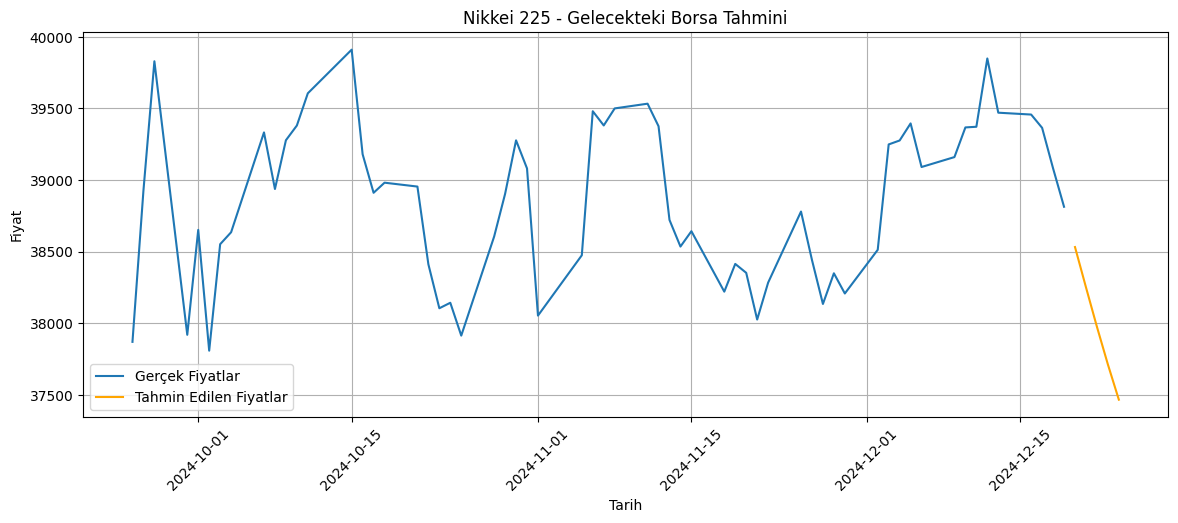

In [16]:
plt.figure(figsize=(14, 5))
plt.plot(data.index[-60:], close_prices[-60:], label="Gerçek Fiyatlar")
plt.plot(future_dates, predictions, label="Tahmin Edilen Fiyatlar", color='orange')
plt.title(f"{borsa_adi} - Gelecekteki Borsa Tahmini")
plt.xlabel("Tarih")
plt.ylabel("Fiyat")
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.show()

# Tahmin Sonuçlarını Tablo Olarak Göster

In [17]:
prediction_table = pd.DataFrame({
    'Tarih': [date.strftime('%Y-%m-%d') for date in future_dates],
    'Tahmin Edilen Fiyat': predictions.flatten()
})
print("\nTahmin Sonuçları:")
print(prediction_table)


Tahmin Sonuçları:
        Tarih  Tahmin Edilen Fiyat
0  2024-12-20         38532.328125
1  2024-12-21         38251.589844
2  2024-12-22         37975.871094
3  2024-12-23         37712.898438
4  2024-12-24         37466.648438


# Ek Analiz Fonksiyonları

In [18]:
def plot_real_vs_forecast():
    """
    Gerçek son 10 günü ve gelecek tahminleri karşılaştırır.
    """
    real_last_10_days = close_prices[-last_n_days:].flatten()
    plt.figure(figsize=(12, 6))
    plt.plot(data.index[-last_n_days:], real_last_10_days, label="Son 10 Gün Gerçek Fiyatları", marker='o', color='blue')
    plt.plot(future_dates, predictions.flatten(), label="Gelecek Tahmin", marker='o', color='red')
    plt.title(f"{borsa_adi} - Son 10 Gün ve Gelecek Tahmin")
    plt.xlabel("Tarih")
    plt.ylabel("Fiyat")
    plt.legend()
    plt.grid()
    plt.show()

def plot_daily_change_and_volatility():
    """
    Günlük fiyat değişim yüzdesini ve volatiliteyi çizer.
    """
    data['Daily Change (%)'] = data['Close'].pct_change() * 100
    data['Volatility'] = data['Daily Change (%)'].rolling(window=10).std()
    plt.figure(figsize=(12, 6))
    plt.plot(data.index[-60:], data['Daily Change (%)'][-60:], label="Günlük Fiyat Değişimi (%)", color='purple')
    plt.plot(data.index[-60:], data['Volatility'][-60:], label="10 Günlük Volatilite", color='orange', linestyle='--')
    plt.title(f"{borsa_adi} - Günlük Fiyat Değişimi ve Volatilite")
    plt.xlabel("Tarih")
    plt.ylabel("Yüzde (%)")
    plt.legend()
    plt.grid()
    plt.show()

def plot_moving_averages_and_rsi():
    """
    Hareketli ortalamaları ve RSI göstergesini çizer.
    """
    data['SMA_10'] = data['Close'].rolling(window=10).mean()
    data['SMA_30'] = data['Close'].rolling(window=30).mean()

    # RSI Hesaplama
    delta = data['Close'].diff(1)
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(window=14).mean()
    avg_loss = loss.rolling(window=14).mean()
    rs = avg_gain / avg_loss
    data['RSI'] = 100 - (100 / (1 + rs))

    # SMA Grafiği
    plt.figure(figsize=(12, 6))
    plt.plot(data.index[-60:], data['Close'][-60:], label="Kapanış Fiyatı", color='blue')
    plt.plot(data.index[-60:], data['SMA_10'][-60:], label="10 Günlük SMA", color='green')
    plt.plot(data.index[-60:], data['SMA_30'][-60:], label="30 Günlük SMA", color='orange')
    plt.title(f"{borsa_adi} - Hareketli Ortalamalar")
    plt.xlabel("Tarih")
    plt.ylabel("Fiyat")
    plt.legend()
    plt.grid()
    plt.show()

    # RSI Grafiği
    plt.figure(figsize=(12, 6))
    plt.plot(data.index[-60:], data['RSI'][-60:], label="RSI (14 Gün)", color='purple')
    plt.axhline(70, color='red', linestyle='--', label="Aşırı Alım (70)")
    plt.axhline(30, color='green', linestyle='--', label="Aşırı Satım (30)")
    plt.title(f"{borsa_adi} - RSI (Relative Strength Index)")
    plt.xlabel("Tarih")
    plt.ylabel("RSI")
    plt.legend()
    plt.grid()
    plt.show()

# Ek Analizlerin Çalıştırılması

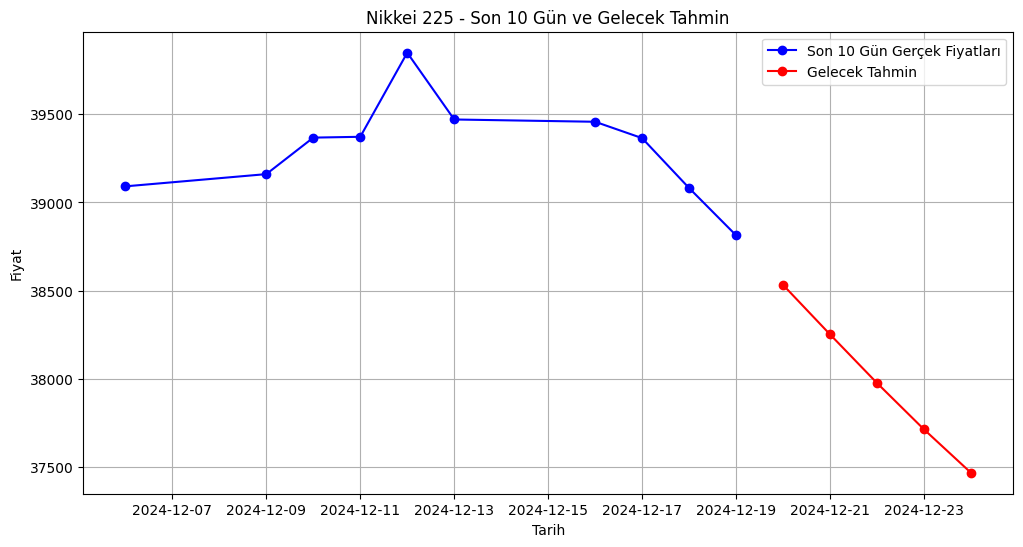

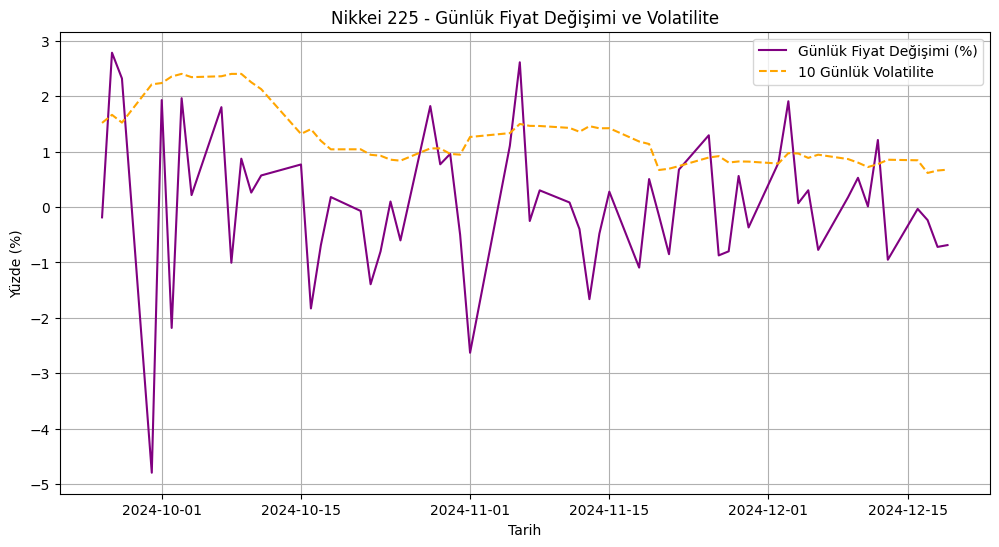

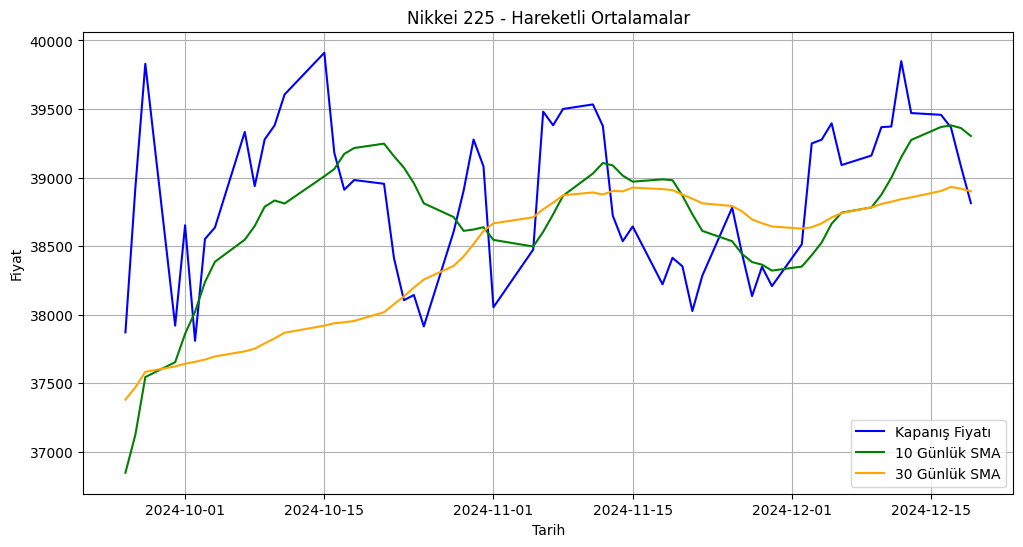

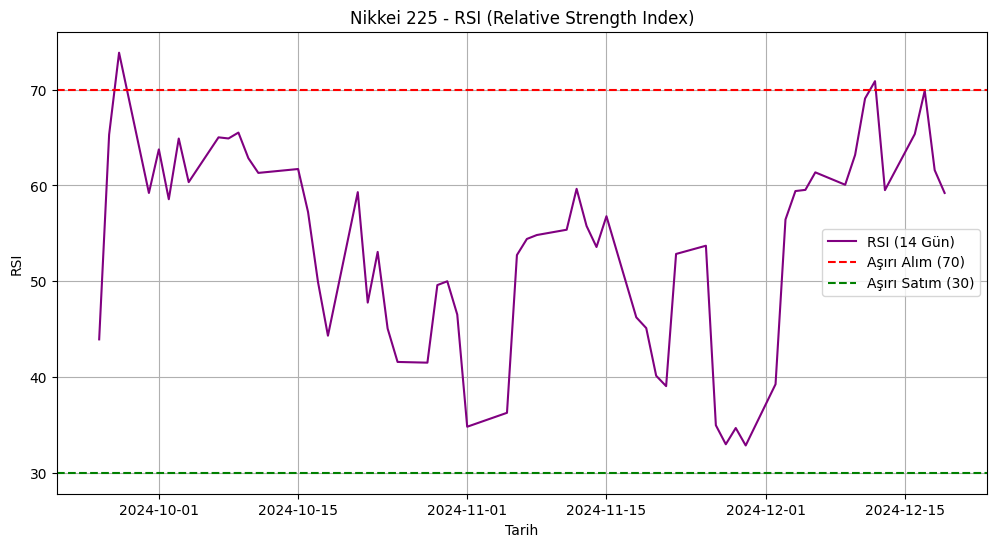

In [19]:
plot_real_vs_forecast()
plot_daily_change_and_volatility()
plot_moving_averages_and_rsi()